This is the notebook for the signal processing of a magnet signal in the lecture Sensors and Signal Processing.

In [48]:
#!pip install plotly

In [49]:
import numpy as np
import pandas as pd
import os
import seaborn
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.linear_model import LinearRegression

# Estimating the sensitivity and resolution of the magnetometer

In [80]:
def moving_average2(signal, window_size):
    """
    Compute the moving average of a time signal using a given window size.

    Parameters:
    signal (numpy.ndarray): The input time signal.
    window_size (int): The size of the moving window.

    Returns:
    numpy.ndarray: The moving average of the input signal.
    """
    # Define the convolution kernel for computing the moving average
    kernel = np.ones(window_size) / window_size

    # Use numpy.convolve() to compute the moving average
    moving_avg = np.convolve(signal, kernel, mode='same')

    return moving_avg

In [85]:
path = f"./data/Raw Data-earth.csv"
df_one = pd.read_csv(path)
df_one = df_one[300:]
# plt.plot(df_one['Time (s)'], df_one['Absolute field (µT)'])
# plt.show()

mean_abs = np.mean(df_one['Absolute field (µT)'])
df_one['Compensated'] = df_one['Absolute field (µT)']-mean_abs
std = np.std(df_one['Compensated'])
print('Resolution:' , std)
# plt.hist(df_one['Compensated'])
# plt.show()

df_one['moved std'] = df_one['Compensated'] + std
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_one['Time (s)'], y=df_one['Compensated'], mode='lines', name='Compensated'))
fig.add_trace(go.Scatter(x=df_one['Time (s)'], y=df_one['moved std'], mode='lines', name='Moved Std'))

fig.update_layout(
    title='Compensated signal and signal moved by 1 STD',
    xaxis_title='Time (s)',
    yaxis_title='Compensated field (µT)'
)
fig.show()

ma = moving_average2(df_one['Compensated'].to_numpy(), 30)



Resolution: 0.14836272814730792


In [99]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_one['Time (s)'], y=df_one['Compensated'], mode='lines', name='Compensated', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df_one['Time (s)'], y=ma, mode='lines', name='Moving Average', line=dict(color='red')))
fig.update_layout(
    title=dict(text='Compensated Signal and Moving Average', font=dict(size=24)),
    xaxis=dict(title=dict(text='Time (s)', font=dict(size=25)),
               tickfont=dict(size=12)),
    yaxis=dict(title=dict(text='Compensated field (µT)', font=dict(size=18)),
               tickfont=dict(size=12)),
    legend=dict(font=dict(size=12))
)

fig.show()

In [39]:
# Read in file paths

file_paths = [f"./data_raw/Raw Data-{i}.csv" for i in range(1, 5)]
dfs = []

# Iterate over each file, read it into a dataframe, and add a column for experiment index
for idx, file_path in enumerate(file_paths, start=1):
    df = pd.read_csv(file_path)
    df['Experiment_Index'] = idx
    dfs.append(df)

# Put the dataframes together
combined_df = pd.concat(dfs, ignore_index=True)
threshold_value = 100

# Lists for indices where it rises and falls back down to normal values (no external magnetic field)
sharp_rise_indices = []
descent_indices = []
for experiment_idx, group_df in combined_df.groupby('Experiment_Index'):
    # Find sharp rise index
    sharp_rise_index = group_df['Absolute field (µT)'].diff().gt(threshold_value).idxmax()
    sharp_rise_indices.append(sharp_rise_index)

    # Find descent index
    start_index = group_df.index.get_loc(sharp_rise_index)  # Start searching from sharp rise index
    sharp_rise_value = group_df.loc[sharp_rise_index, 'Absolute field (µT)']
    threshold_descent = sharp_rise_value - threshold_value # Make sure the value is really significantly smaller
    descent_index = group_df.iloc[start_index:]['Absolute field (µT)'].lt(threshold_descent).idxmax()
    descent_indices.append(descent_index)

selected_rows = []
for sharp_rise_index, descent_index in zip(sharp_rise_indices, descent_indices):
    selected_rows.append(combined_df.loc[sharp_rise_index:descent_index])

selected_df = pd.concat(selected_rows)

print("Indices where a sharp rise occurs: ", sharp_rise_indices)
print("Indices where it descends again", descent_indices)

Indices where a sharp rise occurs:  [219, 1938, 3778, 5958]
Indices where it descends again [1147, 3071, 5081, 7118]


[0.0012936267516241119, 0.0006477436263677691, -0.0006606787834920368, -0.0013099933991832903]
[0.001291145211980288, 0.0006496608608352168, -0.0006496608608352168, -0.001291145211980288]


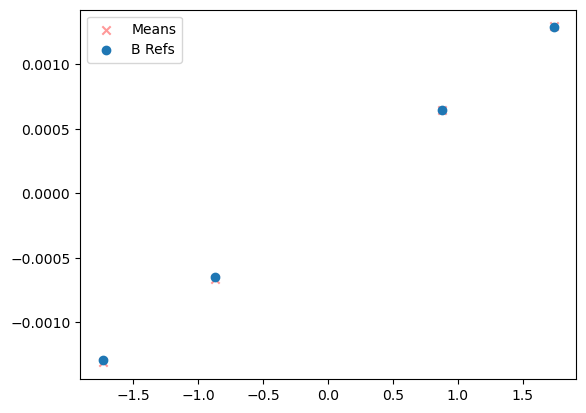

In [40]:
# Get the mean of measurements for each experiment and add it to a list
measured_means = []
for i in range(1,5):
    measured_mean = selected_df[selected_df['Experiment_Index'] == i]['Magnetic Field y (µT)'].mean()
    # measured_mean /= 10^6
    measured_means.append(measured_mean)
measured_means_in_T= [value / 1000000 for value in measured_means]
print(measured_means_in_T)

x = [1,2,3,4]
currents = [1.737, 0.874, -0.874, -1.737]

def B_ref(current):
    mu = 4 * np.pi * 10**(-7)
    N = 124
    R = 0.15
    return mu * (8*current*N) / (np.sqrt(125)*R)

brefs = []
for i in range(0,4):
    brefs.append(B_ref(currents[i]))
print(brefs)

plt.scatter(x=currents, y=measured_means_in_T, label='Means', marker='x', alpha=.4, color='red')
plt.scatter(x=currents, y=brefs, label='B Refs')
plt.legend()
plt.show()

In [41]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=currents, y=measured_means_in_T, mode='markers', marker=dict(size=12, opacity=0.5), name='Measured Means'))
fig.add_trace(go.Scatter(x=currents, y=brefs, mode='markers', marker=dict(size=6, opacity=0.8), name='Calculated B_refs'))

# Add title and axis labels
fig.update_layout(
    title="Scatter Plot of Currents vs Measured B_y and B_ref",
    xaxis_title="Currents [A]",
    yaxis_title="Magnetic Field [T]"
)

# Show the plot
fig.show()

In [42]:
slope, intercept, r_value, _, _ = scipy.stats.linregress(x=currents, y=measured_means_in_T)
print("The Pearson R coefficient for the measured means is: ", r_value)

The Pearson R coefficient for the measured means is:  0.999999528186711


### Tracking Data Extraction

In [47]:
path_to_tracking = "./data_raw/Raw Data-tracking.csv"
df_tracking = pd.read_csv(path_to_tracking)
# threshold_value = 50

# Initialize the experiment index and the flag, for analysis

threshold = 95
df_tracking['Experiment_Index'] = 0
current_index = 0
below_threshold = False  # Flag to track whether we're currently below the threshold

for i in range(len(df_tracking)):
    value = df_tracking.loc[i, 'Absolute field (µT)']

    if value < threshold and not below_threshold:
        # If the value is below the threshold and we are not already in a "below threshold" state
        current_index += 1  # Increment the experiment index
        below_threshold = True  # Set the flag to True since we're now below the threshold
    elif value >= threshold:
        # If the value is above the threshold, reset the below threshold flag
        below_threshold = False

    # Assign the current experiment index
    df_tracking.loc[i, 'Experiment_Index'] = current_index
display(df_tracking)

color_map = {
    1: 'red',
    2: 'blue',
    3: 'green',
    4: 'purple',
    5: 'orange',
    6: 'brown',
    7: 'pink'
}
# Create a figure
fig = go.Figure()

# Add the line plot
fig.add_trace(go.Scatter(x=df_tracking['Time (s)'], y=df_tracking['Absolute field (µT)'],
                         mode='lines', name='Absolute Field'))

# Define colors for each experiment index
colors = {
    1: 'rgba(255, 0, 0, 0.7)',  # red
    2: 'rgba(0, 0, 255, 0.7)',  # blue
    3: 'rgba(0, 255, 0, 0.7)',  # green
    4: 'rgba(128, 0, 128, 0.7)',  # purple
    5: 'rgba(255, 165, 0, 0.7)',  # orange
    6: 'rgba(165, 42, 42, 0.7)',  # brown
    7: 'rgba(255, 192, 203, 0.9)'  # pink
}

# Add shaded regions for each experiment index
for experiment_index in df_tracking['Experiment_Index'].unique():
    df_subset = df_tracking[df_tracking['Experiment_Index'] == experiment_index]
    start_time = df_subset['Time (s)'].min()
    end_time = df_subset['Time (s)'].max()

    # fig = px.line(df_tracking, x='Time (s)', y='Absolute field (µT)', title="Absolute Field vs. Time",
    #           line_shape='linear', render_mode='svg', color='Experiment_Index',
    #           color_discrete_map=color_map)

    fig.add_shape(type='rect',
                  x0=start_time, x1=end_time,
                  y0=df_tracking['Absolute field (µT)'].min(), y1=df_tracking['Absolute field (µT)'].max(),
                  fillcolor=colors[experiment_index], opacity=0.2, line_width=0)

# Update layout
fig.update_layout(title='Absolute Field vs. Time with Shaded Experiment Regions',
                  xaxis_title='Time (s)',
                  yaxis_title='Absolute field (µT)')

# Show the plot
fig.show()


# fig.show()


,Time (s),Magnetic Field x (µT),Magnetic Field y (µT),Magnetic Field z (µT),Absolute field (µT),Experiment_Index
0,0.010507,37.711456,-53.869354,-63.459534,91.384756,1
1,0.020470,37.735016,-53.843094,-63.455551,91.376240,1
...,...,...,...,...,...,...
2220,22.128152,-250.930939,-687.661743,-35.059250,732.853437,7
2221,22.138114,-250.996170,-687.451965,-34.905167,732.671586,7


In [44]:
# Identify plateaus using rolling windows
def find_plateau_regions(df, threshold):
    """
    Find plateau regions in the signal data.

    Args:
    df (pd.DataFrame): DataFrame containing signal data.
    threshold (float): Threshold for detecting plateaus.

    Returns:
    dict: Dictionary containing plateau regions for each column.
    """
    plateau_regions_dict = {}

    for col in df.columns:
        # Smooth the signal data using rolling window averaging
        window_size = 2
        smoothed_signal = df[col].rolling(window=window_size, min_periods=1).mean()

        # Calculate the difference between consecutive smoothed values
        diff_smoothed_signal = smoothed_signal.diff()

        # Find indices where the difference is below the threshold
        plateau_indices = diff_smoothed_signal.abs() < threshold

        plateau_regions = []
        start_index = None
        for index, value in plateau_indices.items():
            if value:  # If the difference is below the threshold
                if start_index is None:
                    start_index = index  # Start of plateau region
            elif start_index is not None:
                end_index = index - 1  # End of plateau region
                plateau_regions.append((start_index, end_index))
                start_index = None

        plateau_regions_dict[col] = plateau_regions

    return plateau_regions_dict

threshold_value = .5
df_trunc = df_tracking.copy()
plateau_regions = find_plateau_regions(df_trunc, threshold_value)
plateau_regions = dict(list(plateau_regions.items())[1:-1])
# print(plateau_regions)

In [45]:
# analyze plateaus and indices for all axes
# Print the values of the second key in plateau_regions_dict
second_key_x = list(plateau_regions.keys())[0]  # 0 = x, 1 = y, 2 = z
plateau_regions_values = plateau_regions[second_key_x]

print(f"Plateau regions for {second_key_x}:")
start_list = []
end_list = []
for start_index, end_index in plateau_regions_values:
    start_list.append(start_index)
    end_list.append(end_index)
    # print(f"Start index: {start_index}, End index: {end_index}")

# Create a line plot of Magnetic Field x vs. Time
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_trunc['Time (s)'], y=df_trunc['Magnetic Field z (µT)'],
                         mode='lines', name='Magnetic Field z', line=dict(color='black')))

# Iterate through each pair of start and end indices
for i, (start_index, end_index) in enumerate(zip(start_list, end_list)):
    # Extract x and y values for the pair
    x_values = [df_trunc.loc[start_index, 'Time (s)'], df_trunc.loc[end_index, 'Time (s)']]
    y_values = [df_trunc.loc[start_index, 'Magnetic Field z (µT)'], df_trunc.loc[end_index, 'Magnetic Field z (µT)']]

    # Assign a different color to each pair
    color = f"hsl({i * 360 / len(start_list)}, 50%, 50%)"  # Adjust saturation and lightness as needed

    # Add a scatter trace for the pair with the assigned color
    fig.add_trace(go.Scatter(x=x_values, y=y_values, mode='markers', marker=dict(color=color, size=9),
                             name=f'Plateau {i+1}'))

# Update layout
fig.update_layout(title='Magnetic Field z vs. Time with Plateau Regions',
                  xaxis_title='Time (s)',
                  yaxis_title='Magnetic Field z (µT)')

# Show the plot
fig.show()


Plateau regions for Magnetic Field x (µT):


In [46]:
def extract_mean(start_list, end_list, ax, experiment_index):
     """Extracts mean for each plateau

     Args:
         start_list (list): _description_
         end_list (list): _description_
         ax (str): x, y, z or nc - defines the axis that the median will find

     Returns:
         _type_: list of medians, index corresponds to A, B, C, D peaks.
     """
     medians = []
     col = ''
     if ax == 'x':
          col = 'Magnetic Field x (µT)'
     elif ax == 'y':
          col = 'Magnetic Field y (µT)'
     elif ax == 'z':
          col = 'Magnetic Field z (µT)'
     else:
          col = 'Absolute field (µT)'
     for i, (start_index, end_index) in enumerate(zip(start_list, end_list)):
          medians.append(np.median(df_trunc.loc[start_index:end_index, col]))
     return medians

meds_x = extract_mean(start_list=start_list, end_list=end_list, ax='x')
meds_x_mT = [val / 1000 for val in meds_x]
print('                (A:1,            B:2,           C:3,           D:4,           NC:5)')
print('Means for x - ', meds_x_mT[1:])
meds_y = extract_mean(start_list=start_list, end_list=end_list, ax='y')
meds_y_mT = [val / 1000 for val in meds_y]
print('Means for y - ', meds_y_mT[1:])
meds_z = extract_mean(start_list=start_list, end_list=end_list, ax='z')
meds_z_mT = [val / 1000 for val in meds_z]
print('Means for z - ', meds_z[1:])

meds_nc = extract_mean(start_list=start_list, end_list=end_list, ax='nc')
print('Means for abs in microT - ', meds_nc[1:])


TypeError: extract_mean() missing 1 required positional argument: 'experiment_index'

In [ ]:
# Matlab values from only one measurement cycle
""" Bx_no_coil=0.0378;
By_no_coil=-0.0541;
Bz_no_coil=-63.516;

BxA_raw=0.102;
ByA_raw=-0.0178;
BzA_raw=-137.679;

BxB_raw=-0.172;
ByB_raw=0.496;
BzB_raw=-137.586;

BxC_raw=0.109;
ByC_raw=-0.099;
BzC_raw=-139.216;

BxD_raw=-0.251;
ByD_raw=-0.688;
BzD_raw=-34.916; """

' Bx_no_coil=0.0378;\nBy_no_coil=-0.0541;\nBz_no_coil=-63.516;\n\nBxA_raw=0.102;\nByA_raw=-0.0178;\nBzA_raw=-137.679;\n\nBxB_raw=-0.172;\nByB_raw=0.496;\nBzB_raw=-137.586;\n\nBxC_raw=0.109;\nByC_raw=-0.099;\nBzC_raw=-139.216;\n\nBxD_raw=-0.251;\nByD_raw=-0.688;\nBzD_raw=-34.916; '

In [ ]:
# TODO: make a method to get the index for 3 axes.
def extract_index(df, col_str, threshold):
    """Extracts the indices where there is sharp rise and sharp descent to get the peaks of the signal.
        This method is specific to a dataframe from Phyphox.
    Args:
        df (pd.Dataframe): Dataframe to extract the indices from
        col_str (str): Column name as String
        threshold (int): Threshold for the difference
    """
    df_new = df.copy()
    df_new['diff'] = df_new[col_str].diff()

    # Find indices of sharp rises and descents
    rise_idx = df_new[df_new['diff'] > threshold].index.tolist()
    descent_idx = df_new[(df_new['diff'].shift(-1) < -threshold)].index.tolist()

    return rise_idx, descent_idx

In [ ]:
# Analyze x and extract indices and subsequently the value to give it to Matlab
t = 40
df_trunc = df_tracking[:400]
rxidx, dxidx = extract_index(df_trunc, 'Magnetic Field x (µT)', t)
rxidx = [index + 1 for index in rxidx]

fig = px.line(df_trunc, x='Time (s)', y='Magnetic Field x (µT)', title="Magnetic Field x vs. Time",
              line_shape='linear', render_mode='svg')

fig.add_scatter(x=df_trunc.loc[rxidx, 'Time (s)'],
                y=df_trunc.loc[rxidx, 'Magnetic Field x (µT)'],
                mode='markers', marker=dict(color='red', size=8), name='Sharp Rise')
fig.add_scatter(x=df_trunc.loc[dxidx, 'Time (s)'],
                y=df_trunc.loc[dxidx, 'Magnetic Field x (µT)'],
                mode='markers', marker=dict(color='red', size=8), name='Descent')
